# $B_z$ extraction is simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
from scipy import optimize
sys.path.append("../CommonUtils/") # https://github.com/glukicov/EDMTracking/blob/master/CommonUtils/CommonUtils.py
import CommonUtils as cu
import RUtils as ru

Welcome to JupyROOT 6.18/04


### Define constants and starting fit parameters

In [2]:
font_size=14 # for plots 

t_min = 0 # us  #TODO 30 for data 
t_max = 210 # us 
print("Starting and end times:", t_min, "to", t_max, "us")
p_min = 1800 # MeV 
p_max = 3100 # MeV 
print("Momentum cuts:", p_min, "to", p_max, "MeV")

omega_a = 1.43934 # MHz (magic)
cu._omega=omega_a #for BNL fits
print("Magic omega set to", cu._omega, "MHz")

g2period = 2*np.pi / omega_a   # 4.3653 us 
print("g-2 period ", round(g2period, 3), "us")
# if(t_min<g2period):
#     raise Exception("Set t_min>g2period for EDM reflection blidning to work")

bin_w = 10*1e-3 # 10 ns 
bin_n = int( round(g2period/bin_w) )
print("Setting bin width of", bin_w*1e3, "ns with", bin_n, "bins")

p0_count=[5000, 64, -0.4, 1.0]
print("Starting pars count (N, tau, A, phi):", *p0_count)
p0_theta_truth=[0.00, 0.17, 0.0]
print("Starting pars TRUTH theta (A_Bz, A_edm, c):", *p0_theta_truth)
p0_theta_blinded=[1.0, 1.0, 1.0]
print("Starting pars theta blinded (A_Bz, A_edm, c):", *p0_theta_blinded)

Starting and end times: 0 to 210 us
Momentum cuts: 1800 to 3100 MeV
Magic omega set to 1.43934 MHz
g-2 period  4.365 us
Setting bin width of 10.0 ns with 437 bins
Starting pars count (N, tau, A, phi): 5000 64 -0.4 1.0
Starting pars TRUTH theta (A_Bz, A_edm, c): 0.0 0.17 0.0
Starting pars theta blinded (A_Bz, A_edm, c): 1.0 1.0 1.0


### Load HDF5 data and apply time and momentum cuts (expecting time data in us) 

In [3]:
#long time to open 1st time
# %time data = pd.read_hdf("../DATA/HDF/Sim/VLEDM.h5", columns=("trackT0", "station", "trackMomentum", "trackMomentumY") )

# #save to open skimed
# data.to_hdf("../DATA/HDF/Sim/VLEDM_skim.h5", key="sim", mode='w', complevel=9, complib="zlib", format="fixed")

#open skimmed 
data = pd.read_hdf("../DATA/HDF/Sim/VLEDM_skim.h5")
mom_cut = ( (data['trackMomentum'] > p_min) & (data['trackMomentum'] < p_max) ) # MeV  
time_cut =( (data['trackT0'] > t_min) & (data['trackT0'] < t_max) ) # MeV  
data=data[mom_cut & time_cut]
data=data.reset_index() # reset index from 0 
N=data.shape[0] 


p=data['trackMomentum']
py=data['trackMomentumY']
t=data['trackT0']
mod_times = cu.get_g2_mod_time(t) # Module the g-2 oscillation time 
theta_y_mrad = np.arctan2(py, p)*1e3 # rad -> mrad
data['mod_times']=mod_times # add to the data frame 
data['theta_y_mrad']=theta_y_mrad # add to the data frame 
# data # display data 
# data.to_hdf("../DATA/HDF/Sim/VLEDM_times.h5", key="sim", mode='w', complevel=9, complib="zlib", format="fixed") # save data 


#TODO for data
#define station cuts to loop over TODO fpr data
# s12_cut = (data['station'] == stations[0])
# s18_cut = (data['station'] == stations[1])
# station_cut = (s12_cut, s18_cut)

print("Total tracks", round(N/1e6,2), "M")

Total tracks 1.35 M


### Digitise data

In [4]:
bin_c, freq = cu.get_freq_bin_c_from_data(mod_times, bin_w, (0, g2period) )
y_err = np.sqrt(freq) # Poissson error 

### Plot counts vs. mod time and fit

In [5]:
#set vars, fit pars, and plot
x,y,y_e = bin_c, freq, y_err
p0_count=[5000, 64, -0.4, 1.0]
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.unblinded_wiggle_fixed, p0_count)
# p0_count=[5000, 64, -0.4, 1.4, 6.0]
# par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.unblinded_wiggle_function, p0_count)

Params: [ 3.159907584e+03  8.986347579e+01 -3.806695208e-01  8.092654227e-02]
Errors: [1.640953484e+01 1.884609959e+01 1.703184035e-03 9.386474926e-03]
𝝌2/dof=2.16


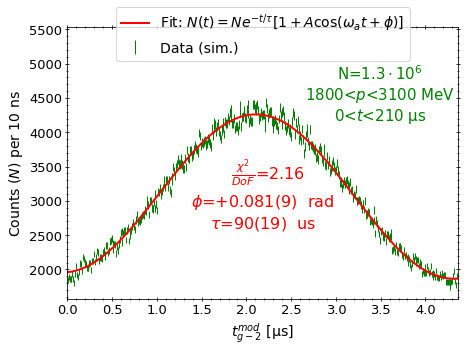

In [6]:
fig, ax = cu.plot(bin_c, freq, y_err=y_err, error=True, elw=1, label="Data (sim.)", fs=font_size, tight=False,
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]", ylabel=r"Counts ($N$) per "+str(int(bin_w*1e3))+" ns")
ax.plot(bin_c, cu.unblinded_wiggle_fixed(bin_c, *par), c="red", 
        label=r'Fit: $N(t)=Ne^{-t/\tau}[1+A\cos(\omega_at+\phi)]$', lw=2)
ax.set_xlim(0, g2period);
ax.set_ylim(np.amin(freq)*0.9, np.amax(freq)*1.25);
leg_fit=cu.legend1_fit(chi2_ndf)
leg_fit=cu.legend_1par(leg_fit, r"$\phi$", par[3], par_e[3], " rad", prec=3)
leg_fit=cu.legend_1par(leg_fit, r"$\tau$", par[1], par_e[1], " us", prec=3)
leg_data="N="+cu.sci_notation(N)+"\n"+str(p_min)+r"<$p$<"+str(p_max)+" MeV\n"+str(t_min)+r"<$t$<"+str(t_max)+r" $\mathrm{\mu}$s"
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1));
cu.textL(ax, 0.5, 0.35, leg_fit, c="r", fs=font_size+2)
cu.textL(ax, 0.8, 0.75, leg_data, fs=font_size+1)
fig.savefig("../fig/bnl_fit.png", dpi=300)

### Set constant phase for the next step

In [7]:
# cu._LT=par[1]
cu._LT=64.95
print("LT set to", round(cu._LT,2), "us")
cu._phi=par[-1]
print("Phase set to", round(cu._phi,2), "rad")
# cu._omega=par[3]
# print("Omega set to", round(cu._omega,2), "MHz")

LT set to 64.95 us
Phase set to 0.08 rad


# Apply blinding

### Resolve angle and times

In [8]:
tmod_abs, weights=cu.get_abs_times_weights(t)
ang=theta_y_mrad

### Digitise data with weights

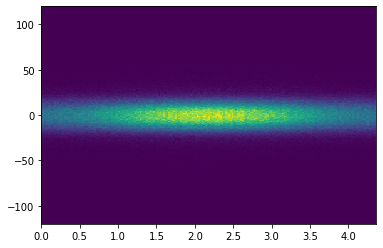

In [26]:
# xy_range=[ [0, g2period], [-0.2, 0.3] ]
xy_range=[ [0, g2period], [-120, 120] ]
xy_bins=(200, 200)
# h,xedges,yedges = np.histogram2d(tmod_abs, ang, weights=weights, bins=xy_bins, range=xy_range);
h,xedges,yedges,image = plt.hist2d(tmod_abs, ang, weights=weights, bins=xy_bins, range=xy_range);

### Expand before profile

In [27]:
(x_w, y_w), binsXY, dBinXY = ru.hist2np(h, (xedges,yedges))

Using passed freq and edges


### Profile

In [28]:
df_binned =cu.Profile(x_w, y_w, None, nbins=40, xmin=np.min(x_w), xmax=np.max(x_w), mean=True, only_binned=True)
x, y, y_e, x_e =df_binned['bincenters'], df_binned['ymean'], df_binned['yerr'], df_binned['xerr']

### Fit

In [29]:
p0_theta_blinded=(-0.04, 0.0, 0.04)
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.thetaY_phase, p0_theta_blinded)

Params: [-0.029294555 -0.005252619  0.020714014]
Errors: [0.015529128 0.014812062 0.010961099]
𝝌2/dof=1.13


### Plot

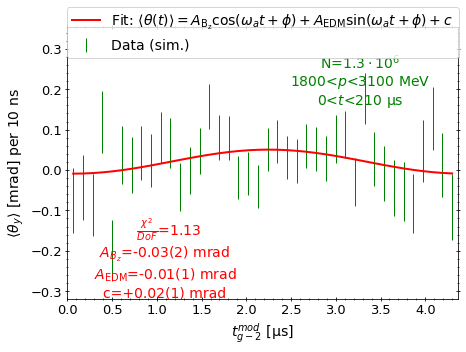

In [30]:
fig, ax = cu.plot(x, y, y_err=y_e, error=True, elw=1, label="Data (sim.)", fs=font_size, tight=False,
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]",  ylabel=r"$\langle\theta_y\rangle$ [mrad] per "+str(int(bin_w*1e3))+" ns")
ax.plot(x, cu.thetaY_phase(x, *par), c="red", 
        label=r'Fit: $\langle \theta(t) \rangle =  A_{\mathrm{B_z}}\cos(\omega_a t + \phi) + A_{\mathrm{EDM}}\sin(\omega_a t + \phi) + c$', lw=2)
ax.set_xlim(0, g2period);
ax.set_ylim(-np.amax(y)*1.8, np.amax(y)*2.0);
leg_data="N="+cu.sci_notation(N)+"\n"+str(p_min)+r"<$p$<"+str(p_max)+" MeV\n"+str(t_min)+r"<$t$<"+str(t_max)+r" $\mathrm{\mu}$s"
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1));
cu.textL(ax, 0.75, 0.8, leg_data, fs=font_size)
leg_fit=cu.legend1_fit(chi2_ndf)
leg_fit=cu.legend_1par(leg_fit, r"$A_{B_{z}}$", par[0], par_e[0], "mrad")
leg_fit=cu.legend_1par(leg_fit, r"$A_{\mathrm{EDM}}$", par[1], par_e[1], "mrad")
leg_fit=cu.legend_1par(leg_fit, "c", par[2], par_e[2], "mrad")
cu.textL(ax, 0.25, 0.12, leg_fit, fs=font_size, c="r")
fig.savefig("../fig/bz_fit_"+str(t_min)+"_"+str(t_max)+".png", dpi=300)